1. 
2. Почему подтянулось на одно значение меньше
3. Пофиксить нули в изначальных данных? Что делать, если GCV тоже будет нулевое?
4. Добавить данные через request
5. Добавить периодическое включение
6. Оптимизировать код на новые/другие терминалы
7. Посмотреть, что за такая большая GCV 12+

In [1]:
import pandas as pd

In [2]:
WH_flow_df = pd.read_csv('C:/Users/user/Documents/IDE/data/NG/Wilhelmshaven_flow_2023_05_12_160150.csv')
WH_GCV_df = pd.read_csv('C:/Users/user/Documents/IDE/data/NG/Wilhelmshaven_GCV__2023_05_12_160436.csv')
BEG_flow_df = pd.read_csv('C:/Users/user/Documents/IDE/data/NG/Baltic_Energy_Gate_flow_2023_05_12_160908.csv')
BEG_GCV_df = pd.read_csv('C:/Users/user/Documents/IDE/data/NG/Baltic_Energy_Gate_GCV__2023_05_12_160946.csv')
BBH_flow_df = pd.read_csv('C:/Users/user/Documents/IDE/data/NG/BRUNSBUETTEL_HAFEN_flow_2023_05_12_162127.csv')
BBH_GCV_df = pd.read_csv('C:/Users/user/Documents/IDE/data/NG/BRUNSBUETTEL_HAFEN_GCV_2023_05_12_161110.csv')


In [3]:
# I will use "periodFrom" as date series "index".
# Converting columns to datetime format.
WH_flow_df['periodFrom'] = pd.to_datetime(WH_flow_df['periodFrom'],dayfirst=False)
WH_GCV_df['periodFrom'] = pd.to_datetime(WH_GCV_df['periodFrom'],dayfirst=False)
BEG_flow_df['periodFrom'] = pd.to_datetime(BEG_flow_df['periodFrom'],dayfirst=False)
BEG_GCV_df['periodFrom'] = pd.to_datetime(BEG_GCV_df['periodFrom'],dayfirst=False)
BBH_flow_df['periodFrom'] = pd.to_datetime(BBH_flow_df['periodFrom'],dayfirst=False)
BBH_GCV_df['periodFrom'] = pd.to_datetime(BBH_GCV_df['periodFrom'],dayfirst=False)

### Solving missing GCV data entries.

During the analysis I encountered this problem that for Baltic Energy Gate Terminal for some days with gas flow data there is now GCV data.  
I looked into it and there is no GCV data for the starting period of Terminal working.  
So, maybe there was some technical problems with data collection.  
Anyway, this problem could happen for any date.  
So I'm going resolve it this way:  
I will merge (by "left join") GCV data with gas flow data for each respective Terminal (keeping in mind that gas flow and GCV data should be downloaded for the same period).    
And then, if the is some missing GCV data I would fill it with the average GCV for the period.  
This is probably not the best option, but it will do for now.  
Maybe I will get back to it later.

In [5]:
# Creating DataFrames for each Terminal

BEG_flow_df = BEG_flow_df[['periodFrom','value']]
BEG_flow_df.rename(columns={"value": "Baltic_Energy_Gate_flow, kWh/d"},inplace=True)

BEG_GCV_df = BEG_GCV_df[['periodFrom','value']]
BEG_GCV_df.rename(columns={"value": "Baltic_Energy_Gate_GCV, kWh/Nm3"},inplace=True)

BEG_df = BEG_flow_df.merge(right=BEG_GCV_df, how='left',left_on='periodFrom',right_on='periodFrom')

In [6]:
WH_flow_df = WH_flow_df[['periodFrom','value']]
WH_flow_df.rename(columns={"value": "Wilhelmshaven_flow, kWh/d"},inplace=True)

WH_GCV_df = WH_GCV_df[['periodFrom','value']]
WH_GCV_df.rename(columns={"value": "Wilhelmshaven_GCV, kWh/Nm3"},inplace=True)

WH_df = WH_flow_df.merge(right=WH_GCV_df, how='left',left_on='periodFrom',right_on='periodFrom')

In [7]:
BBH_flow_df = BBH_flow_df[['periodFrom','value']]
BBH_flow_df.rename(columns={"value": "Brunsbuettel_Hafen_flow, kWh/d"},inplace=True)

BBH_GCV_df = BBH_GCV_df[['periodFrom','value']]
BBH_GCV_df.rename(columns={"value": "Brunsbuettel_Hafen_GCV, kWh/Nm3"},inplace=True)

BBH_df = BBH_flow_df.merge(right=BBH_GCV_df, how='left',left_on='periodFrom',right_on='periodFrom')

In [8]:
# Calculating average GCV for each Terminal
mean_GCV_WH = WH_df['Wilhelmshaven_GCV, kWh/Nm3'].mean(skipna=True)
mean_GCV_BBH = BBH_df['Brunsbuettel_Hafen_GCV, kWh/Nm3'].mean(skipna=True)
mean_GCV_BEG = BEG_df['Baltic_Energy_Gate_GCV, kWh/Nm3'].mean(skipna=True)

In [9]:
# Defining function GCV_fill that will fill missing GCV data
def GCV_fill(entry, Terminal):
    if pd.isna(entry) == True:
        if Terminal == 'WH':
            return mean_GCV_WH
        if Terminal == 'BBH':
            return mean_GCV_BBH
        if Terminal == 'BEG':
            return mean_GCV_BEG
    else:
        return entry

In [10]:
WH_df['Wilhelmshaven_GCV, kWh/Nm3'] = WH_df['Wilhelmshaven_GCV, kWh/Nm3'].apply(GCV_fill, Terminal='WH')
BBH_df['Brunsbuettel_Hafen_GCV, kWh/Nm3'] = BBH_df['Brunsbuettel_Hafen_GCV, kWh/Nm3'].apply(GCV_fill, Terminal='BBH') 
BEG_df['Baltic_Energy_Gate_GCV, kWh/Nm3'] = BEG_df['Baltic_Energy_Gate_GCV, kWh/Nm3'].apply(GCV_fill, Terminal='BEG')  

In [13]:
display(WH_df)

,periodFrom,"Wilhelmshaven_flow, kWh/d","Wilhelmshaven_GCV, kWh/Nm3"
0,2022-12-20 06:00:00,22790.0,11.606000
1,2022-12-21 06:00:00,44577326.0,11.797000
2,2022-12-22 06:00:00,44786631.0,11.906000
3,2022-12-23 06:00:00,48754135.0,11.907000
4,2022-12-24 06:00:00,100323735.0,11.907000
...,...,...,...
138,2023-05-07 06:00:00,123927012.0,11.768000
139,2023-05-08 06:00:00,128732100.0,11.399958
140,2023-05-09 06:00:00,128990019.0,11.397917
141,2023-05-10 06:00:00,129041097.0,11.401625


### Creating DataFrame for the plot

Now I want to create a dataframe where we'll have a date range as "index".  
Then I'll add flows and GCV data by merging ("left join") data to this "index".  
The point is that downloaded dataframeS with terminal's data have different amount of entries,  
as Terminals have gas flows on different dates.  
So this "index" will serve as base for this dataframe.

In [14]:
# Creating date range.
merged_df = pd.DataFrame(pd.date_range(start='2022-09-01 06:00:00', end='2023-05-10 06:00:00', freq='D'), columns=['periodFrom'])

In [15]:
# Merging dataframes.
merged_df = merged_df.merge(right=WH_df, how='left', on='periodFrom')
#merged_df.drop(columns=['periodFrom', 'pointKey','pointLabel','indicator','unit'], inplace=True)
#merged_df.rename(columns={"value": "Wilhelmshaven_flow, kWh/d"},inplace=True)

merged_df = merged_df.merge(right=BBH_df, how='left', on='periodFrom')
#merged_df.drop(columns=['periodFrom', 'pointKey','pointLabel','indicator','unit'], inplace=True)
#merged_df.rename(columns={"value": "Wilhelmshaven_GCV, kWh/Nm3"},inplace=True)

merged_df = merged_df.merge(right=BEG_df, how='left', on='periodFrom')
#merged_df.drop(columns=['periodFrom', 'pointKey','pointLabel','indicator','unit'], inplace=True)
#merged_df.rename(columns={"value": "Baltic_Energy_Gate_flow, kWh/d"},inplace=True)


In [17]:
display(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   periodFrom                       252 non-null    datetime64[ns]
 1   Wilhelmshaven_flow, kWh/d        142 non-null    float64       
 2   Wilhelmshaven_GCV, kWh/Nm3       142 non-null    float64       
 3   Brunsbuettel_Hafen_flow, kWh/d   99 non-null     float64       
 4   Brunsbuettel_Hafen_GCV, kWh/Nm3  99 non-null     float64       
 5   Baltic_Energy_Gate_flow, kWh/d   140 non-null    float64       
 6   Baltic_Energy_Gate_GCV, kWh/Nm3  140 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 15.8 KB


None

In [24]:
# Converting kWh/day to GWh/day
merged_df['Wilhelmshaven_flow, kWh/d'] = merged_df['Wilhelmshaven_flow, kWh/d']/1000/1000
merged_df['Baltic_Energy_Gate_flow, kWh/d'] = merged_df['Baltic_Energy_Gate_flow, kWh/d']/1000/1000
merged_df['Brunsbuettel_Hafen_flow, kWh/d'] = merged_df['Brunsbuettel_Hafen_flow, kWh/d']/1000/1000

In [25]:
# Renaming columns accordingly
merged_df.rename(columns={"Wilhelmshaven_flow, kWh/d": "Wilhelmshaven_flow, GWh/d"},inplace=True)
merged_df.rename(columns={"Baltic_Energy_Gate_flow, kWh/d": "Baltic_Energy_Gate_flow, GWh/d"},inplace=True)
merged_df.rename(columns={"Brunsbuettel_Hafen_flow, kWh/d": "Brunsbuettel_Hafen_flow, GWh/d"},inplace=True)

In [31]:
# Adding columns with flow in cubic meters by dividing Wh by GCV.
merged_df['Wilhelmshaven_flow, mln_Nm3/d'] = merged_df['Wilhelmshaven_flow, GWh/d'] / merged_df['Wilhelmshaven_GCV, kWh/Nm3']
merged_df['Brunsbuettel_Hafen_flow, mln_Nm3/d'] = merged_df['Brunsbuettel_Hafen_flow, GWh/d'] / merged_df['Brunsbuettel_Hafen_GCV, kWh/Nm3']
merged_df['Baltic_Energy_Gate_flow, mln_Nm3/d'] = merged_df['Baltic_Energy_Gate_flow, GWh/d'] / merged_df['Baltic_Energy_Gate_GCV, kWh/Nm3']

In [32]:
display(merged_df.head())
display(merged_df.info())
display(merged_df[merged_df['periodFrom'] == '2023-04-01 06:00:00'])

,periodFrom,"Wilhelmshaven_flow, GWh/d","Wilhelmshaven_GCV, kWh/Nm3","Brunsbuettel_Hafen_flow, GWh/d","Brunsbuettel_Hafen_GCV, kWh/Nm3","Baltic_Energy_Gate_flow, GWh/d","Baltic_Energy_Gate_GCV, kWh/Nm3","Wilhelmshaven_flow, mln_Nm3/d","Brunsbuettel_Hafen_flow, mln_Nm3/d","Baltic_Energy_Gate_flow, mln_Nm3/d"
0,2022-09-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-05 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   periodFrom                          252 non-null    datetime64[ns]
 1   Wilhelmshaven_flow, GWh/d           142 non-null    float64       
 2   Wilhelmshaven_GCV, kWh/Nm3          142 non-null    float64       
 3   Brunsbuettel_Hafen_flow, GWh/d      99 non-null     float64       
 4   Brunsbuettel_Hafen_GCV, kWh/Nm3     99 non-null     float64       
 5   Baltic_Energy_Gate_flow, GWh/d      140 non-null    float64       
 6   Baltic_Energy_Gate_GCV, kWh/Nm3     140 non-null    float64       
 7   Wilhelmshaven_flow, mln_Nm3/d       142 non-null    float64       
 8   Brunsbuettel_Hafen_flow, mln_Nm3/d  99 non-null     float64       
 9   Baltic_Energy_Gate_flow, mln_Nm3/d  140 non-null    float64       
dtypes: datetime64[ns](1), floa

None

,periodFrom,"Wilhelmshaven_flow, GWh/d","Wilhelmshaven_GCV, kWh/Nm3","Brunsbuettel_Hafen_flow, GWh/d","Brunsbuettel_Hafen_GCV, kWh/Nm3","Baltic_Energy_Gate_flow, GWh/d","Baltic_Energy_Gate_GCV, kWh/Nm3","Wilhelmshaven_flow, mln_Nm3/d","Brunsbuettel_Hafen_flow, mln_Nm3/d","Baltic_Energy_Gate_flow, mln_Nm3/d"
212,2023-04-01 06:00:00,151.484042,11.314875,44.604248,12.461,23.631958,11.406,13.388044,3.579508,2.071888


Now I want to create a visualization for these gas flows using matplotlib library.  
I want to create two stackplots for flow in GWh/day and in 1000 m3/day.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

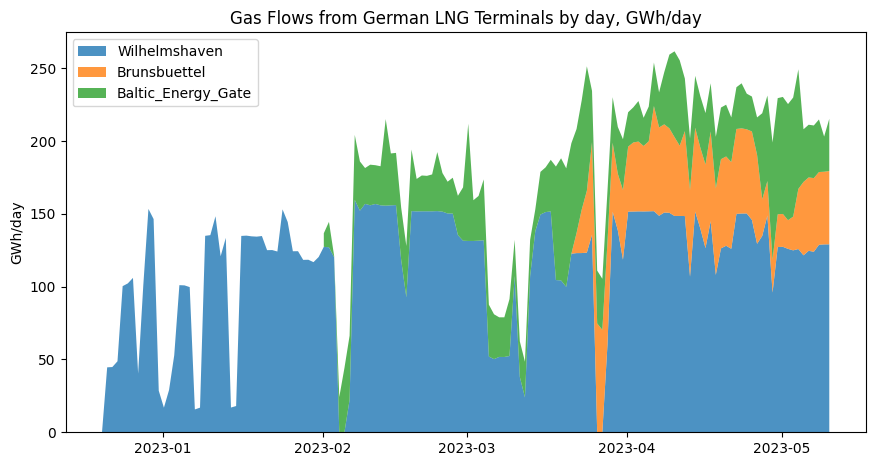

In [30]:
#fig, ax = plt.subplots()
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.stackplot(merged_df['periodFrom'], merged_df['Wilhelmshaven_flow, GWh/d'], merged_df['Brunsbuettel_Hafen_flow, GWh/d'], merged_df['Baltic_Energy_Gate_flow, GWh/d'],
             labels=['Wilhelmshaven', 'Brunsbuettel','Baltic_Energy_Gate'], alpha=0.8,
             #colors = ['mediumblue', 'darkred', 'lawngreen']
             )
ax.legend(loc='upper left')
ax.set_title('Gas Flows from German LNG Terminals by day, GWh/day')
#ax.set_xlabel('Day')
ax.set_ylabel('GWh/day')

plt.show()

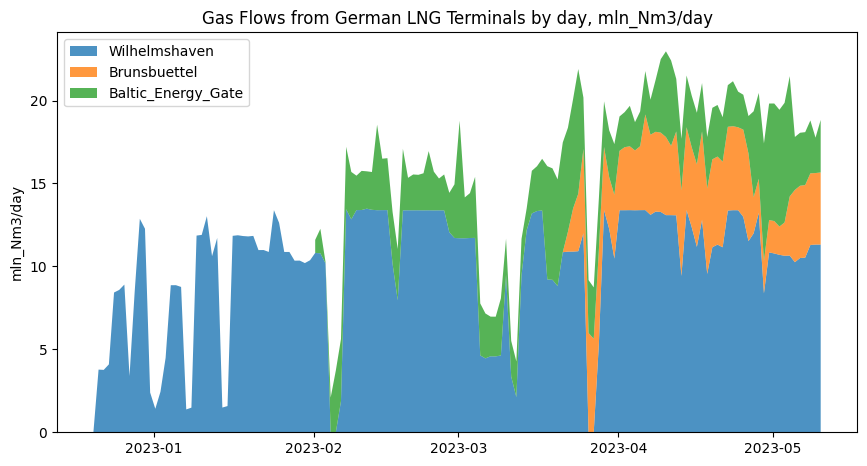

In [35]:
#fig, ax = plt.subplots()
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.stackplot(merged_df['periodFrom'], merged_df['Wilhelmshaven_flow, mln_Nm3/d'], merged_df['Brunsbuettel_Hafen_flow, mln_Nm3/d'], merged_df['Baltic_Energy_Gate_flow, mln_Nm3/d'],
             labels=['Wilhelmshaven', 'Brunsbuettel','Baltic_Energy_Gate'], alpha=0.8,
             #colors = ['mediumblue', 'darkred', 'lawngreen']
             )
ax.legend(loc='upper left')
ax.set_title('Gas Flows from German LNG Terminals by day, mln_Nm3/day')
#ax.set_xlabel('Day')
ax.set_ylabel('mln_Nm3/day')

plt.show()